In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [2]:
df=pd.read_csv("Beximco_dataset.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-03-08,16.0987,16.0987,16.0987,16.0987,16.052361,12733
1,2013-03-11,16.0791,16.0791,16.0791,16.0791,16.032816,6126
2,2013-03-12,15.9809,15.9809,15.3134,15.8043,15.758809,92795
3,2013-03-13,15.8043,15.8043,15.8043,15.8043,15.758809,0
4,2013-03-14,15.8043,15.8043,15.8043,15.8043,15.758809,0


In [3]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
df.index

DatetimeIndex(['2013-03-08', '2013-03-11', '2013-03-12', '2013-03-13',
               '2013-03-14', '2013-03-15', '2013-03-18', '2013-03-19',
               '2013-03-20', '2013-03-21',
               ...
               '2022-03-15', '2022-03-16', '2022-03-17', '2022-03-18',
               '2022-03-21', '2022-03-22', '2022-03-23', '2022-03-24',
               '2022-03-25', '2022-03-28'],
              dtype='datetime64[ns]', name='Date', length=2290, freq=None)

In [5]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

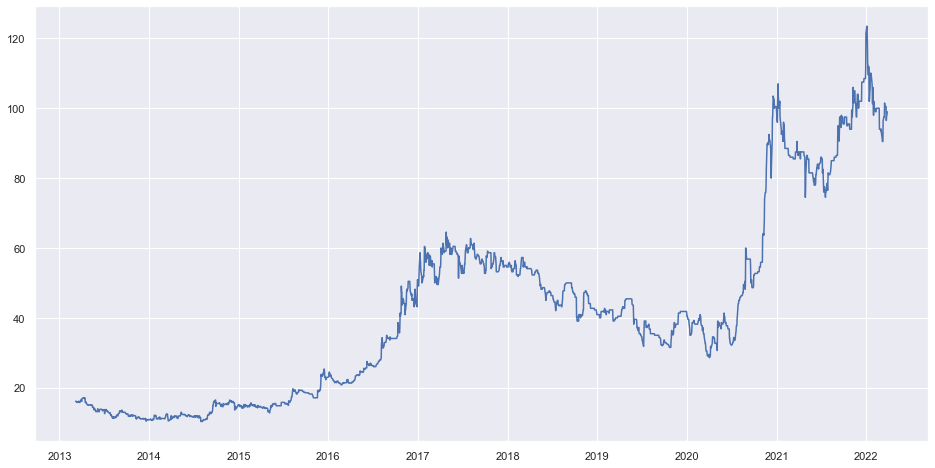

In [7]:
#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Discharge history')

In [8]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close','Open'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data['Close'][i]
    new_dataset["Open"][i]=data["Open"][i]

In [9]:
test_data=df.sort_index(ascending=True,axis=0)
test_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    test_dataset["Date"][i]=data['Date'][i]    
    test_dataset["Close"][i]=data["Close"][i]

In [10]:
#test_dataset

In [10]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:1500,:]
valid_data=final_dataset[1500:,:]

In [11]:
test_dataset.index=test_dataset.Date
test_dataset.drop("Date",axis=1,inplace=True)

test_final_dataset=test_dataset.values

test_train_data=test_final_dataset[0:1500,:]
test_valid_data=test_final_dataset[1500:,:]

In [12]:
train_data=new_dataset.iloc[0:1500]

In [13]:
test_train_data=new_dataset.iloc[0:1500]

In [16]:
#train_data

In [14]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [15]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(test_final_dataset)


In [16]:
x_train_data.shape[0]

1440

In [17]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [18]:
# COMPILE THE MODEL

lstm_model.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
#  FIT THE MODEL
lstm_model.fit(x_train_data,y_train_data,epochs=5,batch_size=1,verbose=2)

Epoch 1/5
1440/1440 - 25s - loss: 1.5458e-04 - 25s/epoch - 17ms/step
Epoch 2/5
1440/1440 - 26s - loss: 1.3917e-04 - 26s/epoch - 18ms/step
Epoch 3/5
1440/1440 - 25s - loss: 1.2326e-04 - 25s/epoch - 17ms/step
Epoch 4/5
1440/1440 - 25s - loss: 1.2725e-04 - 25s/epoch - 17ms/step
Epoch 5/5
1440/1440 - 25s - loss: 1.3493e-04 - 25s/epoch - 17ms/step


In [21]:
# Take a sample of a dataset to make stock price predictions using the LSTM model

inputs_data=test_dataset[len(test_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
discharge=lstm_model.predict(X_test)
discharge=scaler.inverse_transform(discharge)

In [83]:
#inputs_data

In [22]:
# Save the LSTM model
lstm_model.save("saved_discharge-model.h252")

INFO:tensorflow:Assets written to: saved_discharge-model.h252\assets


INFO:tensorflow:Assets written to: saved_discharge-model.h252\assets


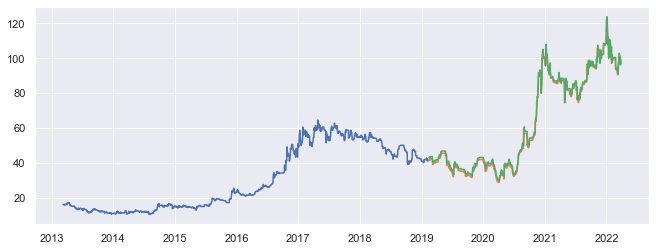

In [24]:
# Visualize the predicted stock costs with actual stock costs
train_data=test_dataset.iloc[0:1500]
valid_data=test_dataset.iloc[1500:]
valid_data['Predictions']=discharge
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(valid_data['Close'], valid_data['Predictions']))
rms

1.897635232394001